In [169]:
%load_ext autoreload
%autoreload 2

import geoopt
import torch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from geoopt.manifolds.lorentz import Lorentz
from geoopt.manifolds.lorentz import math

from torch.utils.data import TensorDataset, DataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


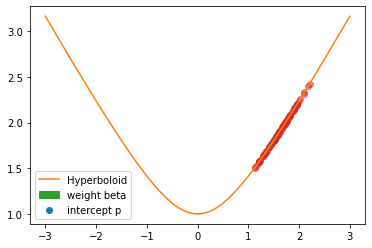

In [172]:
def sample_params(dim):
    # Generate model parameters
    p = torch.randn((1, dim)) # sample points (~N(0,1))
    p = man.projx(p) # project onto the hyperboloid 
    man._check_point_on_manifold(p[0])
    orig = man.origin((1, dim))
    beta = torch.randn((1, dim)) 
    beta /= beta.norm(dim=-1)
    beta = man.proju(orig, beta)
    beta = man.transp(orig, p, beta)
    return p, beta

def plot_params(p, beta):
    p_np = p.numpy()
    beta_np = beta.numpy()
    lins_x = np.linspace(-3, 3, 100)
    linx_y = np.sqrt(k + lins_x**2)
    plt.plot(lins_x, linx_y, color="C1", label="Hyperboloid")
    plt.scatter(p_np[:, 1], p_np[:, 0], label="intercept p")
    plt.arrow(p_np[0, 1], p_np[0, 0], beta_np[0, 1], beta_np[0, 0], 
        width=0.01, color="C2", label="weight beta")
    plt.legend()

def generate_data(n, p, beta, dim):
    x = torch.randn(n, 1)
    y = man.expmap(p, x * beta)

    orig = man.origin((1, dim))
    eps = torch.randn(n, dim) * 0.1
    eps = man.proju(orig, eps)
    eps = man.transp(orig, y, eps)
    ynoise = man.expmap(y, eps)

    return x, ynoise

k = 1 # choose curvature parameter
d = 1
dim = d + 1
man = Lorentz(k=k)
n = 100
p, beta = sample_params(dim)
x, y = generate_data(n, p, beta, dim)

if d == 1:
    plot_params(p, beta)
    plt.scatter(y[:, 1], y[:, 0], alpha=0.5, color='C3', label='data')
    plt.show()


Loss: 64.8777084350586
Loss: 15.58560562133789
Loss: 4.265384197235107
Loss: 1.5353124141693115
Loss: 0.8266299962997437
Loss: 0.6241915225982666
Loss: 0.5600599646568298
Loss: 0.537788987159729
Loss: 0.5295037627220154
Loss: 0.5262800455093384
Loss: 0.5249974727630615
Loss: 0.5244743824005127
Loss: 0.524263322353363
Loss: 0.5241787433624268
Loss: 0.524139940738678
Loss: 0.5241280794143677
Loss: 0.5241201519966125
Loss: 0.5241208672523499
Loss: 0.5241208672523499
Loss: 0.5241180062294006
Training loss: 0.5241
Validation loss:0.594107985496521


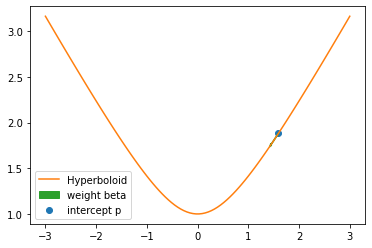

In [173]:
class GeodesicRegressor():
    def __init__(self, K, dim, man):
        self.K = K
        self.dim = dim
        self.man = man
        q, alpha = sample_params(dim)
        self.q = torch.autograd.Variable(q, requires_grad=True)
        self.alpha = torch.autograd.Variable(alpha, requires_grad=True)

    def fit(self, X, Y, epochs=20, lr=0.005, verbose=False):
        n = X.shape[0]

        dataset = TensorDataset(X, Y)
        dataloader = DataLoader(dataset, batch_size=n)
        losses = []
        for e in range(epochs):
            for X, Y in dataloader:
                
                Y_hat = self.man.expmap(self.q, X * self.alpha)
                loss = torch.sum(self.man.dist2(Y, Y_hat))
                print(f"Loss: {loss.item()}")
                
                # Optimization step
                loss.backward()
                with torch.no_grad():

                    # Get riemannian gradient 
                    dq = self.man.egrad2rgrad(self.q, self.q.grad)
                    qnew = self.man.expmap(self.q, -lr * dq)
                    # Gradient of alpha should be in the tangent space of q
                    dalpha = self.man.egrad2rgrad(self.q, self.alpha.grad)
                    alphanew = self.alpha - (lr * dalpha)
                    alphanew = self.man.transp(self.q, qnew, alphanew)

                    self.alpha.zero_()
                    self.alpha.add_(alphanew)
                    self.q.zero_()
                    self.q.add_(qnew)

                self.alpha.grad.zero_()
                self.q.grad.zero_()

            losses.append(loss.detach().numpy())

        print(f'Training loss: {losses[-1]:.4}')

    def predict(self, X):
        Y_hat = man.expmap(self.q, X * self.alpha)
        return Y_hat

model = GeodesicRegressor(k, dim, man)
model.fit(x[:n//2], y[:n//2])
yhat = model.predict(x[n//2:])
val_loss = torch.sum(man.dist2(y[n//2:], yhat))
print(f"Validation loss:{val_loss}")

plot_params(
    model.q.detach(), 
    model.alpha.detach())